# Compile and Train the GPT2 Model using the Transformers Trainer API with the SST2 Dataset for Multi-Node Multi-GPU Training

1. [Introduction](#Introduction)  
2. [Development Environment](#Development-Environment)
    1. [Installation](#Installation)  
    2. [SageMaker Environment](#SageMaker-Environment)
3. [SageMaker Training Job](#SageMaker-Training-Job)  
    1. [Training with Native PyTorch + SM DDP](#Training-with-Native-PyTorch-+-SM-DDP) 
    2. [Training with SageMaker Training Compiler](#Training-with-SageMaker-Training-Compiler)  
4. [Analysis](#Analysis)  

## SageMaker Training Compiler Overview

SageMaker Training Compiler is a capability of SageMaker that makes these hard-to-implement optimizations to reduce training time on GPU instances. The compiler optimizes DL models to accelerate training by more efficiently using SageMaker machine learning (ML) GPU instances. SageMaker Training Compiler is available at no additional charge within SageMaker and can help reduce total billable time as it accelerates training. 

SageMaker Training Compiler is integrated into the AWS Deep Learning Containers (DLCs). Using the SageMaker Training Compiler enabled AWS DLCs, you can compile and optimize training jobs on GPU instances with minimal changes to your code. Bring your deep learning models to SageMaker and enable SageMaker Training Compiler to accelerate the speed of your training job on SageMaker ML instances for accelerated computing. 

For more information, see [SageMaker Training Compiler](https://docs.aws.amazon.com/sagemaker/latest/dg/training-compiler.html) in the *Amazon SageMaker Developer Guide*.

## Introduction

In this demo, you'll use Hugging Face's transformers and datasets libraries with Amazon SageMaker Training Compiler to train the gpt-2 model on the Stanford Sentiment Treebank v2 (SST2) dataset. To get started, we need to set up the environment with a few prerequisite steps, for permissions, configurations, and so on. 

**NOTE:** You can run this demo in SageMaker Studio, SageMaker notebook instances, or your local machine with AWS CLI set up. If using SageMaker Studio or SageMaker notebook instances, make sure you choose one of the PyTorch-based kernels, Python 3 (PyTorch x.y Python 3.x CPU Optimized) or conda_pytorch_p36 respectively.

**NOTE:** This notebook uses four ml.p4d.24xlarge instances that have multiple GPUs. If you don't have enough quota, see [Request a service quota increase for SageMaker resources](https://docs.aws.amazon.com/sagemaker/latest/dg/regions-quotas.html#service-limit-increase-request-procedure). 

## Development Environment 

### Installation

This example notebook requires the **SageMaker Python SDK v2.108.0** and **transformers v4.21**.

In [1]:
!pip install "sagemaker>=2.108.0" botocore boto3 awscli s3fs typing-extensions "torch==1.11.0" pandas numpy --upgrade

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 49.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.5/132.5 KB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 83.8 MB/s eta 0:00:00:00:01
  Using cached s3fs-2022.8.2-py3-none-any.whl (27 kB)
  Using cached aiobotocore-2.4.0-py3-none-any.whl (65 kB)
  Using cached fsspec-2022.8.2-py3-none-any.whl (140 kB)
INFO: pip is looking at multiple versions of numpy to determine which version is compatible with other requirements. This could take a while.
  Using cached numpy-1.23.4-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
INFO: pip is looking at multiple versions of pandas to determine which version is compatible with other requirements. This could take a while.
  Using cached pandas-1.5.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.2 MB)
INFO: pip is look

In [2]:
!pip install "transformers==4.21" datasets --upgrade

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p38/bin/python -m pip install --upgrade pip' command.


In [3]:
import botocore
import boto3
import sagemaker
import transformers
import pandas as pd

print(f"sagemaker: {sagemaker.__version__}")
print(f"transformers: {transformers.__version__}")

/home/ec2-user/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


sagemaker: 2.112.2
transformers: 4.21.0


**NOTE:** Copy and run the following code if you need to upgrade ipywidgets for datasets library and restart the kernel. This is needed if the installation is not applied to the current kernel.

```python
%%capture
import IPython
!conda install -c conda-forge ipywidgets -y
# has to restart kernel for the updates to be applied
IPython.Application.instance().kernel.do_shutdown(True) 
```

### SageMaker Environment 

In [4]:
import sagemaker

sess = sagemaker.Session()

# sagemaker session bucket -> used for uploading data, models and logs
# sagemaker will automatically create this bucket if it not exists
sagemaker_session_bucket = None
if sagemaker_session_bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    sagemaker_session_bucket = sess.default_bucket()

role = sagemaker.get_execution_role()
sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {sess.boto_region_name}")

sagemaker role arn: arn:aws:iam::875423407011:role/AdminRole
sagemaker bucket: sagemaker-us-west-2-875423407011
sagemaker session region: us-west-2


## SageMaker Training Job

To create a SageMaker training job, we use a HuggingFace/PyTorch estimator. Using the estimator, you can define which training script should SageMaker use through entry_point, which instance_type to use for training, which hyperparameters to pass, and so on.

When a SageMaker training job starts, SageMaker takes care of starting and managing all the required machine learning instances, picks up the HuggingFace Deep Learning Container, uploads your training script, and downloads the data from sagemaker_session_bucket into the container at /opt/ml/input/data.

In [5]:
# Here we configure the training job. Please configure the appropriate options below:

EPOCHS = 1000

# Choose between Causal Language Model and Masked Language Model
LANGUAGE_MODELING_LOSS = "clm"  # or "mlm"
SEQ_LEN_ARG = "block_size" if LANGUAGE_MODELING_LOSS == "clm" else "max_seq_length"

MODEL_NAME = "gpt2"
TOKENIZER_NAME = "gpt2"

MODEL_CONFIG = "model_type"

# For more information about the options, please look into the training scripts

# Select Instance type for training
INSTANCE_TYPE = "ml.p4d.24xlarge"
NUM_INSTANCES = 2
# Since ml.p4d.24xlarge instance has 8 GPUs, we set num_gpus_per_instance to 8
num_gpus_per_instance = 8

First, we define some basic parameters common to all estimators.

**Note**: We recommend you to turn the SageMaker Debugger's profiling and debugging tools off to avoid additional overheads.

In [6]:
estimator_args = dict(
    entry_point=f"run_{LANGUAGE_MODELING_LOSS}.py",
    source_dir="./scripts",
    instance_type=INSTANCE_TYPE,
    instance_count=NUM_INSTANCES,
    role=role,
    volume_size=100,
    py_version="py38",
    disable_profiler=True,  # Disabling SageMaker Profiler to avoid overheads during benchmarking
    debugger_hook_config=False,  # Disabling SageMaker Debugger to avoid overheads during benchmarking
    base_job_name="trcomp-pt-example",
    metric_definitions=[
        {"Name": "summary_train_runtime", "Regex": "'train_runtime': ([0-9.]*)"},
        {
            "Name": "summary_train_samples_per_second",
            "Regex": "'train_samples_per_second': ([0-9.]*)",
        },
        {"Name": "summary_train_steps_per_second", "Regex": "'train_steps_per_second': ([0-9.]*)"},
        {"Name": "summary_train_loss", "Regex": "'train_loss': ([0-9.]*)"},
        {"Name": "epoch", "Regex": "'epoch': ([0-9.]*)"},
        {"Name": "train_loss", "Regex": "'loss': ([0-9.]*)"},
        {"Name": "learning_rate", "Regex": "'learning_rate': ([0-9.]*)"},
    ],
)

Next, we define some basic arguments to be passed to the training script.

In [7]:
# hyperparameters are passed to the training entrypoint as arguments
hyperparameters = {
    MODEL_CONFIG: MODEL_NAME,
    "tokenizer_name": TOKENIZER_NAME,
    "dataset_name": "glue",
    "dataset_config_name": "sst2",
    "do_train": True,
    "do_eval": False,
    "fp16": True,
    "per_device_train_batch_size": 32,
    "num_train_epochs": EPOCHS,
    "overwrite_output_dir": True,
    "evaluation_strategy": "no",
    "logging_strategy": "epoch",
    "output_dir": "/opt/ml/model",
    "dataloader_drop_last": True,
    SEQ_LEN_ARG: 512,
    "preprocessing_num_workers": 12,
}

In the following sections, we will create estimators and start training.

### Training with Native PyTorch + SM DDP

The batch size below is the maximum batch we could fit into the memory of an ml.p4d.24xlarge instance. If you change the model, instance type, sequence length, and other parameters, you need to do some experiments to find the largest batch size that will fit into GPU memory. We also use Automatic Mixed Precision for faster training.

This example uses HuggingFace training script run_clm.py, which you can find it inside the scripts folder.

In [8]:
from sagemaker.pytorch import PyTorch

# The original LR was set for a batch of 32. Here we are scaling learning rate with batch size.
hyperparameters["learning_rate"] = (
    float("5e-5") / 32 * hyperparameters["per_device_train_batch_size"]
)

# configure the training job
native_estimator = PyTorch(
    **estimator_args,
    framework_version="1.11",
    hyperparameters=hyperparameters,
    distribution={
        "smdistributed": {"dataparallel": {"enabled": True}}
    },  # Use SageMaker Distributed Data Parallel to train across nodes/GPUs.
)

# Start the training job
native_estimator.fit(wait=False)
native_estimator.latest_training_job.name

'trcomp-pt-example-2022-10-13-20-02-06-586'

### Training with SageMaker Training Compiler 

Compilation through Training Compiler changes the memory footprint of the model. Most commonly, this manifests as a reduction in memory utilization and a consequent increase in the largest batch size that can fit on the GPU. Note that if you want to change the batch size, you must adjust the learning rate appropriately.

In [9]:
from sagemaker.huggingface import HuggingFace, TrainingCompilerConfig

# with SageMaker Training Compiler we are able to fit a larger batch into memory
hyperparameters["per_device_train_batch_size"] = 64

# The original LR was set for a batch of 32. Here we are scaling learning rate with batch size.
hyperparameters["learning_rate"] = (
    float("5e-5") / 32 * hyperparameters["per_device_train_batch_size"]
)

# configure the training job
optimized_estimator = HuggingFace(
    compiler_config=TrainingCompilerConfig(),
    **estimator_args,
    transformers_version="4.21",
    pytorch_version="1.11",
    hyperparameters=hyperparameters,
    distribution={"pytorchxla": {"enabled": True}},
)

# start the training job
optimized_estimator.fit(wait=False)
optimized_estimator.latest_training_job.name

'trcomp-pt-example-2022-10-13-20-02-07-185'

### Wait for training jobs to complete


In [23]:
waiter = native_estimator.sagemaker_session.sagemaker_client.get_waiter(
    "training_job_completed_or_stopped"
)
waiter.wait(TrainingJobName=native_estimator.latest_training_job.name)
waiter = optimized_estimator.sagemaker_session.sagemaker_client.get_waiter(
    "training_job_completed_or_stopped"
)
waiter.wait(TrainingJobName=optimized_estimator.latest_training_job.name)

## Analysis

**Note:** If the estimator object is no longer available due to a kernel break or refresh, you need to directly use the training job name and manually attach the training job to a new HuggingFace estimator. For example:

```python
estimator = HuggingFace.attach("your_huggingface_training_job_name")
```

### Load logs of the training job *with* SageMaker Training Compiler

In [24]:
%%capture optimized

# access the logs of the optimized training job
optimized_estimator.sagemaker_session.logs_for_job(optimized_estimator.latest_training_job.name)

### Load logs of the training job *without* SageMaker Training Compiler

In [25]:
%%capture native

# access the logs of the native training job
native_estimator.sagemaker_session.logs_for_job(native_estimator.latest_training_job.name)

### Create helper functions for analysis

In [26]:
from ast import literal_eval
from collections import defaultdict
from matplotlib import pyplot as plt


def _summarize(captured):
    final = []
    for line in captured.stdout.split("\n"):
        cleaned = line.strip()
        if "{" in cleaned and "}" in cleaned:
            final.append(cleaned[cleaned.index("{") : cleaned.index("}") + 1])
    return final


def make_sense(string):
    try:
        return literal_eval(string)
    except:
        pass


def summarize(summary):
    final = {"train": [], "eval": [], "summary": {}}
    for line in summary:
        interpretation = make_sense(line.replace("nan", "'nan'"))
        if interpretation:
            if "loss" in interpretation:
                final["train"].append(interpretation)
            elif "eval_loss" in interpretation:
                final["eval"].append(interpretation)
            elif "train_runtime" in interpretation:
                final["summary"].update(interpretation)
    return final

### Plot Optimized vs Native Training Throughput

Visualize average throughputs as reported by HuggingFace and see potential savings.


In [27]:
# Average throughput for the native PyTorch training as reported by Trainer
n = summarize(_summarize(native))
native_throughput = n["summary"]["train_samples_per_second"]

# Average throughput for the optimized PyTorch training as reported by Trainer
o = summarize(_summarize(optimized))
optimized_throughput = o["summary"]["train_samples_per_second"]

# Calculate percentage speedup of optimized PyTorch over native PyTorch
avg_speedup = f"{round((optimized_throughput/native_throughput-1)*100)}%"

([<matplotlib.axis.XTick at 0x7f2c8b675c10>,
 [Text(1.0, 0, 'PT + SM DDP'), Text(1.5, 0, 'PT + Compiler')])

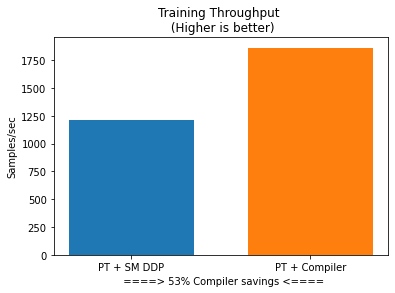

In [28]:
%matplotlib inline

plt.title("Training Throughput \n (Higher is better)")
plt.ylabel("Samples/sec")

plt.bar(x=[1], height=native_throughput, label="PT + SM DDP", width=0.35)
plt.bar(x=[1.5], height=optimized_throughput, label="PT + Compiler", width=0.35)

plt.xlabel("  ====> {} Compiler savings <====".format(avg_speedup))
plt.xticks(ticks=[1, 1.5], labels=["PT + SM DDP", "PT + Compiler"])

### Convergence of Training Loss

SageMaker Training Compiler does not affect the model convergence behavior. Here, we see the decrease in training loss is similar with and without SageMaker Training Compiler


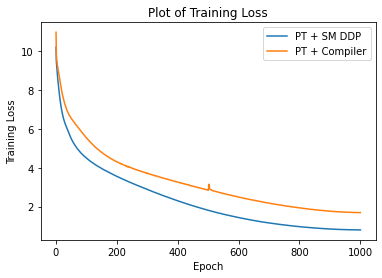

In [29]:
vanilla_loss = [i["loss"] for i in n["train"]]
vanilla_epochs = [i["epoch"] for i in n["train"]]
optimized_loss = [i["loss"] for i in o["train"]]
optimized_epochs = [i["epoch"] for i in o["train"]]

plt.title("Plot of Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.plot(vanilla_epochs, vanilla_loss, label="PT + SM DDP")
plt.plot(optimized_epochs, optimized_loss, label="PT + Compiler")
plt.legend()

### Training Stats

Let's compare various training metrics with and without SageMaker Training Compiler. SageMaker Training Compiler provides an increase in training throughput which translates to a decrease in total training time.



In [30]:
import pandas as pd

pd.DataFrame([n["summary"], o["summary"]], index=["PT + SM DDP", "PT + Compiler"])

,train_runtime,train_samples_per_second,train_steps_per_second,train_loss,epoch
PT + SM DDP,1305.6774,1216.227,2.298,2.340201,1000.0
PT + Compiler,852.8778,1861.932,1.173,3.286979,1000.0


In [31]:
speedup = (
    (n["summary"]["train_runtime"] - o["summary"]["train_runtime"])
    * 100
    / n["summary"]["train_runtime"]
)
print(
    f"SageMaker Training Compiler is about {int(speedup)}% faster in terms of total training time."
)

SageMaker Training Compiler is about 34% faster in terms of total training time.


### Total Billable Time

Finally, the decrease in total training time results in a decrease in the billable seconds from SageMaker.

In [32]:
def BillableTimeInSeconds(name):
    describe_training_job = (
        optimized_estimator.sagemaker_session.sagemaker_client.describe_training_job
    )
    details = describe_training_job(TrainingJobName=name)
    return details["BillableTimeInSeconds"]

In [33]:
Billable = {}
Billable["PT + SM DDP"] = BillableTimeInSeconds(native_estimator.latest_training_job.name)
Billable["PT + Compiler"] = BillableTimeInSeconds(optimized_estimator.latest_training_job.name)
pd.DataFrame(Billable, index=["BillableSecs"])

,PT + SM DDP,PT + Compiler
BillableSecs,2582,1980


In [34]:
speedup = (Billable["PT + SM DDP"] - Billable["PT + Compiler"]) * 100 / Billable["PT + SM DDP"]
print(f"SageMaker Training Compiler integrated PyTorch was {int(speedup)}% faster in summary.")

SageMaker Training Compiler integrated PyTorch was 23% faster in summary.


## Clean up

Stop all training jobs launched if the jobs are still running.

In [35]:
import boto3

sm = boto3.client("sagemaker")


def stop_training_job(name):
    status = sm.describe_training_job(TrainingJobName=name)["TrainingJobStatus"]
    if status == "InProgress":
        sm.stop_training_job(TrainingJobName=name)


stop_training_job(native_estimator.latest_training_job.name)
stop_training_job(optimized_estimator.latest_training_job.name)

Also, to find instructions on cleaning up resources, see [Clean Up](https://docs.aws.amazon.com/sagemaker/latest/dg/ex1-cleanup.html) in the *Amazon SageMaker Developer Guide*.